## plotting a neuron

In [1]:
import numpy as np
import McNeuron

from keras.models import Sequential
from keras.layers.core import Dense, Reshape
from keras.layers.recurrent import LSTM

import matplotlib.pyplot as plt
from copy import deepcopy
import os

from numpy import linalg as LA

%matplotlib inline

Using Theano backend.


In [2]:
import scipy.io
#mat = scipy.io.loadmat("/Volumes/Arch/Dropbox/HG-GAN/03-Data/Matlab format/part 1.mat")
mat = scipy.io.loadmat("/Volumes/Arch/Dropbox/HG-GAN/03-Data/Matlab format/sample.mat")
mat.keys()

['N', '__version__', '__header__', '__globals__']

/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


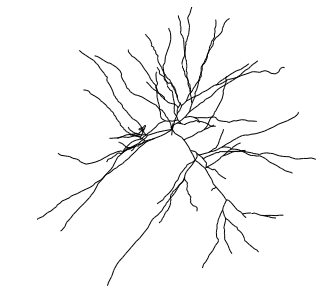

In [3]:
#tmp = mat['neuron_data'][2500][3]
tmp = mat['N']
neuron = McNeuron.Neuron(file_format = 'Matrix of swc' , input_file = tmp)
McNeuron.visualize.plot_2D(neuron ,size = 4)

In [9]:
neuron.n_node

1274

101


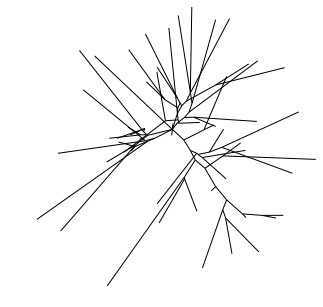

In [20]:
n = neuron.mesoscale_subsample(150)
#n = neuron.subsample_main_nodes()
McNeuron.visualize.plot_2D(n ,size = 4)
print n.n_node

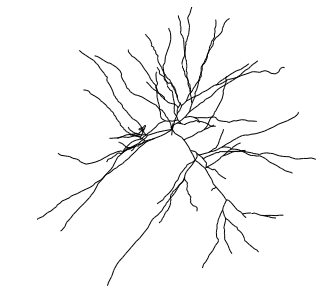

In [6]:
McNeuron.visualize.plot_2D(neuron ,size = 4)

#### Subsampling methods

In [ ]:
# self is neuron!
def get_main_points(self):
    """
    gets the index of branching points and end points.
    """
    (branch_index,) = np.where(self.branch_order[self.n_soma:]==2)
    (endpoint_index,) = np.where(self.branch_order[self.n_soma:]==0)
    selected_index = np.union1d(branch_index + self.n_soma, endpoint_index + self.n_soma)
    selected_index = np.append(range(self.n_soma), selected_index)
    return selected_index

def parent_id(self, selected_index):
    """
    Gives back the parent id of all the selected_index of the neuron. 
    Parameters
    ----------
    selected_index: numpy array
        the index of nodes
    Returns
    -------
    parent_id: the index of parent of each element in selected_index in this array.
    """
    parent_id = np.array([],dtype = int)
    for i in selected_index:
        p = self.parent_index[i]
        while(~np.any(selected_index == p)):
            p = self.parent_index[p]
        (ind,) = np.where(selected_index==p)
        parent_id = np.append(parent_id , ind) 
    return parent_id

def neuron_with_selected_nodes(self, selected_index):
    """
    Gives back a new neuron made up with the selected_index nodes of self.
    if node A is parent (or grand parent) of node B in the original neuron, it is the same for the new neuron.
    Parameters
    ----------
    selected_index: numpy array
        the index of nodes from original neuron for making new neuron
    Returns
    -------
    Neuron: the subsampled neuron
    """
    parent = parent_id(self, selected_index)
    # making the list of nodes
    n_list = []
    for i in range(selected_index.shape[0]):
        n = McNeuron.Node()
        n.xyz = self.nodes_list[selected_index[i]].xyz
        n.r = self.nodes_list[selected_index[i]].r
        n.type = self.nodes_list[selected_index[i]].type
        n_list.append(n)
    # adjusting the childern and parents for the nodes.
    for i in np.arange(1,selected_index.shape[0]):
        j = parent[i]
        n_list[i].parent = n_list[j]
        n_list[j].add_child(n_list[i])
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = n_list)

def find_sharpest_fork(self, Nodes):
    """
    Looks at the all branching point in the Nodes list, selects those which both its children are end points and finds
    the closest pair of childern (the distance between children).
    Parameters
    ----------
    Nodes: list
    the list of Node
        
    Returns
    -------
    sharpest_pair: array
        the index of the pair of closest pair of childern
    distance: float
        Distance of the pair of children
    """
    pair_list = []
    Dis = np.array([])
    for n in Nodes:       
        if n.parent is not None:
            if n.parent.parent is not None:
                a = n.parent.children
                if(isinstance(a, list)):
                    if(len(a)==2):
                        n1 = a[0]
                        n2 = a[1]
                        if(len(n1.children) == 0 and len(n2.children) == 0):
                            pair_list.append([n1 , n2])
                            dis = LA.norm(a[0].xyz - a[1].xyz,2)
                            Dis = np.append(Dis,dis)
    if(len(Dis)!= 0):
        (b,) = np.where(Dis == Dis.min())
        sharpest_pair = pair_list[b[0]]
        distance = Dis.min()
    else:
        sharpest_pair = [0,0]
        distance = 0.
    return sharpest_pair, distance

def find_sharpest_fork_general(self, Nodes):
    """
    Looks at the all branching point in the Nodes list, selects those which both its children are end points and finds
    the closest pair of childern (the distance between children).
    Parameters
    ----------
    Nodes: list
    the list of Node
        
    Returns
    -------
    sharpest_pair: array
        the index of the pair of closest pair of childern
    distance: float
        Distance of the pair of children
    """
    pair_list = []
    Dis = np.array([])
    for n in Nodes:       
        if n.parent is not None:
            if n.parent.parent is not None:
                a = n.parent.children
                if(isinstance(a, list)):
                    if(len(a)==2):
                        n1 = a[0]
                        n2 = a[1]
                        pair_list.append([n1 , n2])
                        dis = LA.norm(a[0].xyz - a[1].xyz,2)
                        Dis = np.append(Dis,dis)
    if(len(Dis)!= 0):
        (b,) = np.where(Dis == Dis.min())
        sharpest_pair = pair_list[b[0]]
        distance = Dis.min()
    else:
        sharpest_pair = [0,0]
        distance = 0.
    return sharpest_pair, distance

def remove_pair_replace_node(self, Nodes, pair):
    """
    Removes the pair of nodes and replace it with a new node. the parent of new node is the parent of the pair of node,
    and its location and its radius are the mean of removed nodes.
    Parameters
    ----------
    Nodes: list
    the list of Nodes
    
    pair: array
    The index of pair of nodes. the nodes should be end points and have the same parent.
    
    Returns
    -------
    The new list of Nodes which the pair are removed and a mean node is replaced.
    """
    
    par = pair[0].parent
    loc = pair[0].xyz + pair[1].xyz
    loc = loc/2
    r = pair[0].r + pair[1].r
    r = r/2
    Nodes.remove(pair[1])
    Nodes.remove(pair[0])
    n = McNeuron.Node()
    n.xyz = loc
    n.r = r
    par.children = []
    par.add_child(n)
    n.parent = par
    Nodes.append(n)
    
def remove_pair_adjust_parent(self, Nodes, pair):
    """
    Removes the pair of nodes and adjust its parent. the location of the parent is the mean of the locaton of two nodes.
    
    Parameters
    ----------
    Nodes: list
    the list of Nodes
    
    pair: array
    The index of pair of nodes. the nodes should be end points and have the same parent.
    
    Returns
    -------
    The new list of Nodes which the pair are removed their parent is adjusted.
    """
    
    par = pair[0].parent
    loc = pair[0].xyz + pair[1].xyz
    loc = loc/2
    Nodes.remove(pair[1])
    Nodes.remove(pair[0])
    par.xyz = loc
    par.children = []
    
def prune_shortest_seg(self):
    (endpoint_index,) = np.where(self.branch_order[self.n_soma:]==0)
    #for i in endpoint_index:
        
    
    
def random_subsample(self, num):
    """
    randomly selects a few nodes from neuron and builds a new neuron with them. The location of these node in the new neuron 
    is the same as the original neuron and the morphology of them is such that if node A is parent (or grand parent) of node B
    in the original neuron, it is the same for the new neuron.
    
    Parameters
    ---------- 
    num: int
        number of nodes to be selected randomly.

    Returns
    -------
    Neuron: the subsampled neuron
    """
    
    # select the index of num nodes randomly.
    I = np.arange(self.n_soma, self.n_node)
    np.random.shuffle(I)
    selected_index = I[0:num]
    selected_index = np.union1d(np.arange(self.n_soma), selected_index)
    selected_index = selected_index.astype(int)
    selected_index = np.unique(np.sort(selected_index))
        
    # making a list of node from the selected nodes
    neuron = neuron_with_selected_nodes(self, selected_index)
        
    return neuron

def subsample_main_nodes(self):
    """
    subsamples a neuron with its main node only; i.e endpoints and branching nodes.

    Returns
    -------
    Neuron: the subsampled neuron
    """
    # select all the main points
    selected_index = get_main_points(self)

    # Computing the parent id of the selected nodes    
    neuron = neuron_with_selected_nodes(self, selected_index)
    return neuron

def regular_subsample(self, distance):
    """
    subsamples a neuron from original neuron. It has all the main points of the original neuron, 
    i.e endpoints or branching nodes, are not changed and meanwhile the distance of two consecutive nodes 
    of subsample neuron is around the 'distance'. 
    for each segment between two consecuative main points, a few nodes from the segment will be added to the selected node;
    it starts from the far main point, and goes on the segment toward the near main point. Then the first node which is 
    going to add has the property that it is the farest node from begining on the segment such that its distance from begining is
    less than 'distance'. The next nodes will be selected similarly. this procesure repeat for all the segments.
   
    Parameters
    ---------- 
    distance: float
        the mean distance between pairs of consecuative nodes.

    Returns
    -------
    Neuron: the subsampled neuron
    """
    
    # Selecting the main points: branching nodes and end nodes
    selected_index = get_main_points(self)
    
    # for each segment between two consecuative main points, a few nodes from the segment will be added to the selected node.
    # These new nodes will be selected base on the fact that neural distance of two consecuative nodes is around 'distance'. 
    # Specifically, it starts from the far main point, and goes on the segment toward the near main point. Then the first node which is 
    # going to add has the property that it is the farest node from begining on the segment such that its distance from begining is
    # less than 'distance'. The next nodes will be selected similarly.
    
    for i in selected_index:
        upList = np.array([i],dtype = int)
        index = self.parent_index[i]
        dist = self.distance_from_parent[i]
        while(~np.any(selected_index == index)):
            upList = np.append(upList,index)
            index = self.parent_index[index]
            dist = np.append(dist, sum(self.distance_from_parent[upList]))
        dist = np.append(0,dist)
        (I,) = np.where(np.diff(np.floor(dist/distance))>0)
        I = upList[I]
        selected_index = np.append(selected_index,I)
    selected_index = np.unique(selected_index)
    
    neuron = neuron_with_selected_nodes(self, selected_index)

    return neuron

def regular_subsample_with_fixed_number(self, num):
    """
    gives back a regular subsample neuron (regular means that the distance between consecuative nodes is approximately fixed) 
    such that the number of nodes is 'num'.
    
    Parameters
    ---------- 
    num: int
        number of nodes on the subsampled neuron

    Returns
    -------
    Neuron: the subsampled neuron   
    
    """
    l = sum(self.distance_from_parent)
    branch_number = len(np.where(self.branch_order[self.n_soma:] == 2))
    distance = l/(num - branch_number)
    return regular_subsample(self, distance)

def mesoscale_subsample(self, number):
    main_point = self.subsample_main_nodes()
    Nodes = main_point.nodes_list
    rm = (main_point.n_node - number)/2.
    for remove in range(int(rm)):
        b, m = find_sharpest_fork(self, Nodes)
        remove_pair_adjust_parent(self, Nodes, b)
        
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = Nodes)

def regular_mesoscale_subsample(self, number):
    thresh = 1.
#     n = neuron.subsample(thresh)
#     while(len(n.nodes_list)>number):
#         thresh += 1 
#         n = neuron.subsample(thresh)
#         if(sum(n.branch_order[n.n_soma:]==1)==0):
#             break
#     neuron = n
    Nodes = self.nodes_list
    while(len(Nodes)>number):
        b, m = find_sharpest_fork_general(self, Nodes)
        print m
        if(m>0. and m < thresh):
            remove_pair_replace_node(self, Nodes, b)
        else:
            self = McNeuron.Neuron(file_format = 'only list of nodes', input_file = Nodes)
            thresh = thresh + 1
            self = self.subsample(thresh)
            Nodes = self.nodes_list
            print thresh
        
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = Nodes)


In [ ]:
self= neuron
(endpoint_index,) = np.where(self.branch_order[self.n_soma:]==0)
for i in endpoint_index:
    a = self.nodes_list[i]
    b = a.parent
    while(len(b.children) ==1):
        b = b.parent
    print LA.norm(b.xyz - a.xyz,2)

#### Testing subsamples

In [ ]:
neuron_list = McNeuron.visualize.get_all_path(os.getcwd()+"/Data/Pyramidal/chen")
neuron = McNeuron.Neuron(file_format = 'swc', input_file=neuron_list[19])
# McNeuron.visualize.plot_2D(neuron,size = 4)
# McNeuron.visualize.plot_2D(random_subsample(neuron, 200) ,size = 4)
# McNeuron.visualize.plot_2D(subsample_main_nodes(neuron) ,size = 4)
# McNeuron.visualize.plot_2D(regular_subsample(neuron, distance = 60) ,size = 4)
# McNeuron.visualize.plot_2D(regular_subsample_with_fixed_number(neuron, num = 200) ,size = 4)
#McNeuron.visualize.plot_2D(mesoscale_subsample(neuron, number = 40) ,size = 4)
McNeuron.visualize.plot_2D(regular_mesoscale_subsample(neuron, number = 40) ,size = 4)

In [ ]:
neuron.location

#### Models

In [ ]:
def reducing_data(swc_df, pruning_number=10):
    """
    Parameters
    ----------
    swc_df: dataframe
        the original swc file
    pruning_number: int
        number of nodes remaining at the end of pruning
        
    Returns
    -------
    pruned_df: dataframe
        pruned dataframe
    
    """
    L = []
    for i in range(len(swc_df)):
        L.append(mesoscale_subsample(McNeuron.Neuron(file_format = 'swc', input_file = swc_df[i]), pruning_number))
    
    return L
    
def separate(list_of_neurons):
    """
    Parameters
    ----------
    list_of_neurons: List of Neurons
        
        
    Returns
    -------
    geometry: array of shape (n-1, 3)
        (x, y, z) coordinates of each shape assuming that soma is at (0, 0, 0)
        
    morphology : array of shape (n-1,)
        index of node - index of parent
    """
    Geo = list()
    Morph = list()
    for n in range(len(list_of_neurons)):
        neuron = list_of_neurons[n]
        Geo.append(neuron.location)
        Morph.append(neuron.parent_index)
    
    return Geo, Morph
    
def geometry_generator(n_nodes=10):
    """
    Generator network: fully connected 2-layer network to generate locations
    
    Parameters
    ----------
    n_nodes: int
        number of nodes
    
    Returns
    -------
    model: keras object
        number of models
    """
    
    model = Sequential()
    
    model.add(Dense(input_dim=100, output_dim=512))
    model.add(Activation('tanh'))

    model.add(Dense(input_dim=512, output_dim=512))
    model.add(Activation('tanh'))

    model.add(Dense(input_dim=512, output_dim=n_nodes * 3))
    model.add(Reshape((n_nodes, 3)))
    
    return model

def morphology_generator(n_nodes=10):
    """
    Generator network: fully connected 2-layer network to generate locations
    
    Parameters
    ----------
    n_nodes: int
        number of nodes
    
    Returns
    -------
    model: keras object
        number of models
    """
    
    model = Sequential()
    
    # A keras seq to seq model, with the following characteristics:
    # input length: 1
    # input dimensionality: 100
    # some hidden layers for encoding
    # some hidden layers for decoding
    # output length: n_nodes - 1
    # output dimensionality: n_nodes - 1 (there will finally be a softmax on each output node)
        
    return model

In [ ]:
for i in range(5):
    n_nodes = 10 + 10 * i
    subsampled_neuron = mesoscale_subsample(deepcopy(neuron), n_nodes)
    print 'Number of nodes: %d' % (n_nodes)
    McNeuron.visualize.plot_2D(subsampled_neuron, size = 4)
    #McNeuron.visualize.plot_dedrite_tree(subsampled_neuron)
    
    #plt.show()

In [ ]:
for i in range(20):
    n_nodes = 10 + 10 * i
    subsampled_neuron = mesoscale_subsample_2d(deepcopy(neuron), n_nodes)
    print subsampled_neuron.n_node
    McNeuron.visualize.plot_2D(subsampled_neuron, size = 4, save = str(40+i)+".eps")

In [ ]:
subsampled_neuron.n_node

#### Showing the geometrical data

In [ ]:
tmp = reducing_data(neuron_list[0:20], pruning_number=10)
geo, morph = separate(tmp)

In [ ]:
McNeuron.visualize.plot_2D(tmp[0])

In [ ]:
plt.scatter(tmp[0].location[0,:],tmp[0].location[1,:])

In [ ]:
for n in range(10):
    plt.scatter(geo[n][0,:],geo[n][1,:])
    plt.show()

In [ ]:
McNeuron.visualize.plot_2D(tmp[1])

#### Testing function: separate [works]

In [ ]:
geo, morph = separate(tmp)

In [ ]:
print morph[0]
print morph[1]
print morph[2]

In [ ]:
print geo[6].shape
n = 1
plt.scatter(geo[n][0,:],geo[n][1,:])

#### Testing geometry_generator( ) [works]

In [ ]:
neuron = McNeuron.Neuron(file_format = 'swc', input_file=neuron_list[0])
McNeuron.visualize.plot_2D(neuron)

In [ ]:
n1 = neuron.subsample(100)
McNeuron.visualize.plot_2D(n1)

In [ ]:
McNeuron.visualize.plot_dedrite_tree(n1)

In [ ]:
neuron.n_node

In [ ]:
n1.n_node

In [ ]:
plt.hist(n1.distance_from_parent)

In [ ]:
plt.scatter(n1.location[0,:],n1.location[1,:],s = 7)

In [ ]:
tmp = mat['N'][2500][3]
tmp[0:3,:]